In [5]:
from sklearn.ensemble import RandomForestClassifier
import datetime
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from transformers import BertTokenizer, BertModel
from transformers import get_linear_schedule_with_warmup
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import AdamW
import sys 
import os
sys.path.append(os.path.abspath("/Users/13793/Desktop/aas/stock"))
import processer as processer
import yfinance as yf
import matplotlib.pyplot as plt

In [26]:
stocks = pd.read_csv('C:/Users/13793/Desktop/aas/stock/Stock_with_sentiment.csv', encoding='ISO-8859-1')
stocks['Date'] = pd.to_datetime(stocks['Date'])
stocks['Sentiment_Weighted'] = pd.to_numeric(stocks['Sentiment_Weighted'])
stocks['Sentiment_mean'] = pd.to_numeric(stocks['Sentiment_mean'])
stocks['Tweets'] = pd.to_numeric(stocks['Tweets'])
stocks['Tweets_mean'] = pd.to_numeric(stocks['Tweets_mean'])
stocks['Volume_Change'] = pd.to_numeric(stocks['Volume_Change'])
stocks['Percent_Change_Bin'] = pd.to_numeric(stocks['Percent_Change_Bin'])

stocks



,Ticker,Date,Sentiment_Weighted,Sentiment_mean,Tweets,Tweets_mean,Adj Close,Percent_Change,Percent_Change_Bin,Volume_Change,Volume_Change_Bin,Close,Volume,Low,High,Open
0,aal,2016-03-11,0.090909,0.090909,33,33.000000,40.697010,0.282561,1,-19.880733,0,42.470001,5701500.0,41.700001,42.500000,41.889999
1,aal,2016-03-14,0.210526,0.143576,19,25.000000,40.812004,-1.127042,0,-2.683888,0,42.590000,4568000.0,42.119999,42.700001,42.310001
2,aal,2016-03-15,0.200000,0.106539,45,25.000000,40.352036,0.474946,1,7.817069,1,42.110001,4445400.0,41.980000,42.490002,42.299999
3,aal,2016-03-16,0.341176,0.250568,85,49.666667,40.543686,-0.496327,0,24.363120,2,42.310001,4792900.0,41.590000,42.430000,41.810001
4,aal,2016-03-18,0.081967,0.230479,61,62.333333,41.626507,0.069079,1,-65.397934,0,43.439999,13746000.0,41.750000,43.529999,42.310001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2826,wdc,2016-06-10,0.600000,0.614035,35,58.333333,40.854412,-1.216640,0,-21.877925,0,46.849998,5876700.0,46.430000,47.759998,47.689999
2827,wdc,2016-06-13,0.594595,0.572072,37,30.000000,40.357361,0.259286,1,19.039425,1,46.279999,4591000.0,46.250000,47.490002,46.650002
2828,wdc,2016-06-14,0.710526,0.601707,38,30.333333,40.462002,-0.301729,0,-35.902362,0,46.400002,5465100.0,45.459999,47.430000,46.250000
2829,wdc,2016-06-15,0.333333,0.546151,30,35.000000,40.339916,0.345877,1,-6.151870,0,46.259998,3503000.0,46.009998,47.020000,46.400002


In [32]:
stocks = stocks.sort_values(['Date', 'Ticker'])
model = RandomForestClassifier(random_state=1)
d_train = stocks.loc[stocks['Date'] < datetime.datetime(year=2016, month=4, day=15)].reset_index(drop=True)
d_test = stocks.loc[stocks['Date'] >= datetime.datetime(year=2016, month=4, day=15)].reset_index(drop=True)


In [33]:
# Remove extra columns from train data 
X_train = d_train[["Adj Close", "Volume", "Low", "High", "Open"]].values
y_train = d_train['Percent_Change_Bin'].values

# Remove extra solumns from test data 
X_test = d_test[["Adj Close", "Volume", "Low", "High", "Open"]].values
y_test = d_test['Percent_Change_Bin'].values
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print('\n')

model.fit(X_train, y_train)
prediction = model.predict(X_test)
d_test['Prediction'] = prediction

(670, 5) (670,)
(2161, 5) (2161,)




In [34]:
# Remove extra columns from train data 
X_train = d_train[['Sentiment_Weighted', 'Sentiment_mean', 'Tweets', 'Tweets_mean']].values
y_train = d_train['Percent_Change_Bin'].values

# Remove extra solumns from test data 
X_test = d_test[['Sentiment_Weighted', 'Sentiment_mean', 'Tweets', 'Tweets_mean']].values
y_test = d_test['Percent_Change_Bin'].values

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print('\n')

# Define random forest classifier
model = RandomForestClassifier(random_state=1)

# Train model with training data
model.fit(X_train, y_train)

# Predict the test data 
preds = model.predict(X_test)

# Print the percent of predictions that resulted in investing in a losing stock
print(len(np.where( (preds>0) & (y_test==0) )[0])/len(preds))
print('\n')

# Add predictions to test dataset 
d_test['Preds'] = preds


(670, 4) (670,)
(2161, 4) (2161,)


0.21332716335030077




In [35]:
X_train = d_train[['Sentiment_Weighted', 'Sentiment_mean', 'Tweets', 'Tweets_mean',"Adj Close", "Volume", "Low", "High", "Open"]].values
y_train = d_train['Percent_Change_Bin'].values

# Remove extra solumns from test data 
X_test = d_test[['Sentiment_Weighted', 'Sentiment_mean', 'Tweets', 'Tweets_mean',"Adj Close", "Volume", "Low", "High", "Open"]].values
y_test = d_test['Percent_Change_Bin'].values

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print('\n')

# Define random forest classifier
model = RandomForestClassifier(random_state=1)

# Train model with training data
model.fit(X_train, y_train)

# Predict the test data 
predicts = model.predict(X_test)

# Print the percent of predictions that resulted in investing in a losing stock
print(len(np.where( (preds>0) & (y_test==0) )[0])/len(preds))
print('\n')

# Add predictions to test dataset 
d_test['Predicts'] = predicts

(670, 9) (670,)
(2161, 9) (2161,)


0.21332716335030077




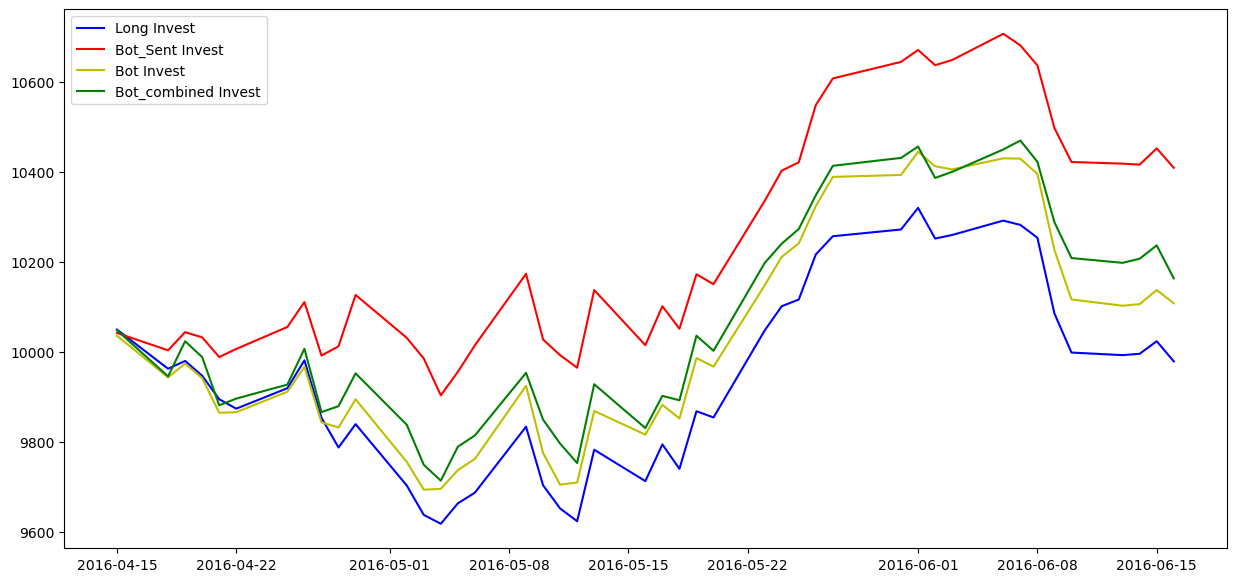

Long-Term Investment: 9979.19 ( -0.21 % )
Bot_sent Trading: 10408.75 ( 4.09 % )
Bot Trading: 10108.1 ( 1.08 % )
Bot_combined Trading: 10163.34 ( 1.63 % )


In [36]:
# Initialize starting capital to test model effectiveness
bot_capital = 10000
bot_sent_capital = 10000
bot_combined_capital = 10000
long_capital = 10000

# Add capital as first data points
bots = [bot_capital]
bots_sent = [bot_sent_capital]
bots_combined = [bot_combined_capital]
longs = [long_capital]

# Get unique dates
dates = d_test['Date'].sort_values().unique()
# For each date
for date in dates:
    # filter dataframe to date
    temp = d_test[d_test['Date']==date]
    
    # Calculate profit from investing equal parts to all tickers in timeframe
    long_capital = long_capital + ((long_capital/len(temp)) * (temp['Percent_Change']/100)).sum()
    
    # Calculate profit from using the Twitter bot to determine what stocks to invest in 
    temp = temp[temp['Prediction']>0]
    bot_capital = bot_capital + ((bot_capital/len(temp)) * (temp['Percent_Change']/100)).sum()
    
    # Calculate profit from using the Twitter bot to determine what stocks to invest in 
    temp = d_test[d_test['Date']==date]
    temp = temp[temp['Preds']>0]
    bot_sent_capital = bot_sent_capital + ((bot_sent_capital/len(temp)) * (temp['Percent_Change']/100)).sum()
    
    # Calculate profit from using the Twitter bot to determine what stocks to invest in 
    temp = d_test[d_test['Date']==date]
    temp = temp[temp['Predicts']>0]
    bot_combined_capital = bot_combined_capital + ((bot_combined_capital/len(temp)) * (temp['Percent_Change']/100)).sum()
    
    # Keep track of the account totals ove time 
    longs.append(long_capital)
    bots.append(bot_capital)
    bots_sent.append(bot_sent_capital)
    bots_combined.append(bot_combined_capital)


    
    
# Plot the accounts balances over time
plt.figure(figsize=(15,7))
plt.plot(dates, longs[1:], c='b', label='Long Invest')
plt.plot(dates, bots_sent[1:], c='r', label='Bot_Sent Invest')
plt.plot(dates, bots[1:], c='y', label='Bot Invest')
plt.plot(dates, bots_combined[1:], c='g', label='Bot_combined Invest')
plt.legend()
plt.show()

# Show the return from each account over time 
print('Long-Term Investment:', round(longs[-1],2), '(', round((longs[-1]-longs[0])/longs[0]*100,2), '% )')
print('Bot_sent Trading:', round(bots_sent[-1],2), '(', round((bots_sent[-1]-bots_sent[0])/bots_sent[0]*100,2), '% )')
print('Bot Trading:', round(bots[-1],2), '(', round((bots[-1]-bots[0])/bots[0]*100,2), '% )')
print('Bot_combined Trading:', round(bots_combined[-1],2), '(', round((bots_combined[-1]-bots_combined[0])/bots_combined[0]*100,2), '% )')